Code to generate expected S11 for antennas at different heights. This is the first part of EIGSEP memo #10, see https://eigsep.github.io/notebooks/EIGSEP_terrain_reflection.html.

The code as used in the memo implictly assumes a relative permittivity of 1 (appropriate for vacuum, not for the canyon) and implements slightly confusing terminolgy. Here, we reproduce the results from the memo and compare with realistic values for the permittivity.

We consider reflections of waves off the canyon walls.

The reflection coefficient assuming normal incidence is
$$R = \left|\frac{\tilde{n}_0-\tilde{n}}{\tilde{n}_0+\tilde{n}}\right|^2, $$
where the complex index of refraction of the canyon is denoted $\tilde{n}$ and the index of refraction of air is $\tilde{n}_0$ (assumed to be 1 here).
The refractive index is related to the complex relative permittivity $\tilde{\epsilon}_r$, which depends on the real-valued relative permittivity $\epsilon_r$ and conductivity $\sigma$ through the following relations:
$$\tilde{n} = \sqrt{\tilde{\epsilon}_r},$$
$$\tilde{\epsilon}_r = \epsilon_r - i \frac{\sigma}{\omega \epsilon_0},$$
with $\omega$ the angular frequency.

Note that the equations here are in SI units and assume a non-magnetic medium. The relative permittivity and conductivity are locally independent quantities. They are related through the Kramers-Kronig relation, but this requires knowing (or assuming a model for) the conductivity as a function of frequency.

The conductivity is related to the resisitivty $\rho$ simply through $\sigma = 1/\rho$.

In cgs units, we get for the permittivity

$$\tilde{\epsilon}_r = \epsilon_r - i \frac{4\pi\sigma}{\omega}.$$
Everything else is the same.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import epsilon_0, c
from scipy.interpolate import interp1d
import healpy as hp
import hera_filters
import eigsep_terrain.utils as etu

%matplotlib widget

/home/christian/Documents/research/eigsep/eigsep_terrain/.venv/lib/python3.12/site-packages/eigsep_terrain/__init__.py:11: UserWarning: img module could not be imported, install extra dependencies from pyproject.toml to enable it.
  warn(


In [2]:
# from the memo
RESISTIVITY_OHM_M = 3e2 # Ohm m, middle of the road?

def conductivity_from_resistivity(resistivity_ohm_m):
    '''Return the conductivity of a material given resistivity [Ohm m].'''
    return 1 / (resistivity_ohm_m * 1.113e-12 * 100)

def permittivity_from_conductivity(conductivity, freqs):
    '''Return the electromagnetic permittivity given a conductivity and a frequency [Hz].'''
    omega = 2 * np.pi * freqs  # Hz
    eta = np.sqrt(1 + 1j * 4 * np.pi * conductivity / omega)
    return eta

def reflection_coefficient(eta, eta0=1):
    '''Return the reflection coefficient crossing from eta0 to eta [permittivity].'''
    return np.abs((eta0 - eta) / (eta0 + eta))**2

def reflectivity(freqs, resistivity_ohm_m=RESISTIVITY_OHM_M, eta0=1):
    conductivity = conductivity_from_resistivity(resistivity_ohm_m)
    eta = permittivity_from_conductivity(conductivity, freqs)
    R = reflection_coefficient(eta, eta0=eta0)
    return R

The memo implements the equations in cgs, although resistivity is given in SI. The conversion to cgs is done in conductivity_from_resisitivty.


In [3]:
si_to_cgs = 4*np.pi*epsilon_0
print(si_to_cgs)  # 1.113e-10 as used above

1.1126500562018527e-10


It is clear from the equations that permittiivty_from_conductivity actually returns the refractive index in the case where $\epsilon_r=1$. The sign difference for the imaginary part does not matter in this case, as long as it is consistent.

In [4]:
S11_NPZ = 'S11_eigsep_bowtie_v000.npz'

def load_S11(freqs, filename=S11_NPZ, termination=None):
    npz = np.load(filename)
    mdl_freqs = npz['freqs']
    if termination is None:
        mdl_S11 = npz['S11']
    else:  # redo S11 for a different termination
        Z = npz['Z']
        gamma = np.abs(Z - termination) / np.abs(Z + termination)
        mdl_S11 = gamma**2
    mdl_interp = interp1d(mdl_freqs, mdl_S11, kind='cubic', fill_value=0, bounds_error=False)
    S11 = mdl_interp(freqs)
    return S11


[  1.          13.55555556  26.11111111  38.66666667  51.22222222
  63.77777778  76.33333333  88.88888889 101.44444444 114.        ]


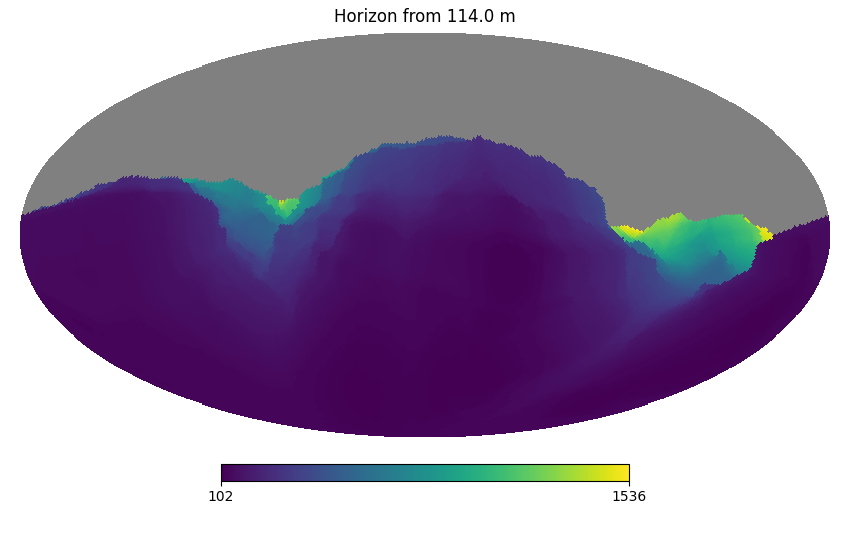

In [5]:
# memo results

NCHAN = 512
freqs = np.linspace(50e6, 250e6, NCHAN)
S11 = load_S11(freqs, filename="S11_eigsep_bowtie_oct25.npz")  # XXX CHB only has this file, might be different from sim.S11_NPZ
df = freqs[1] - freqs[0]
tau_bins = np.linspace(0, 1/(2*df), NCHAN//2+1, endpoint=False)
bin_edges = np.empty(NCHAN//2+2, dtype=tau_bins.dtype)
dbin = tau_bins[1] - tau_bins[0]
bin_edges[:-1] = tau_bins - dbin/2
bin_edges[-1] = tau_bins[-1] + dbin/2
window = hera_filters.dspec.gen_window('bh7', freqs.size)
gamma = reflectivity(freqs)


HORIZON_NPZ = "horizon_models_v000.npz"
npz = np.load(HORIZON_NPZ)
heights = npz["heights"]
print(heights)
hp.mollview(npz["r"][-1], title=f"Horizon from {heights[-1]} m")
plt.show()

Expected height = 1, Actual height = 1.0
Expected height = 5, Actual height = 1.0
Expected height = 10, Actual height = 13.555555555555555
Expected height = 25, Actual height = 26.11111111111111
Expected height = 50, Actual height = 51.22222222222222
Expected height = 75, Actual height = 76.33333333333333
Expected height = 100, Actual height = 101.44444444444444


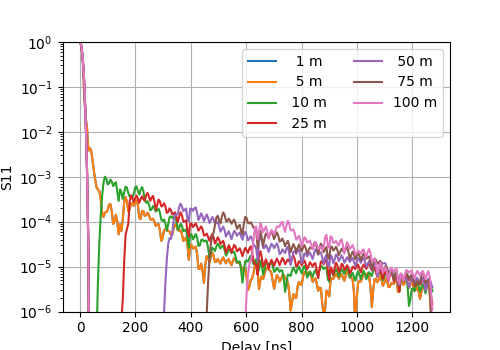

In [6]:
plt.figure(figsize=(5, 3.5))
for height in [1, 5, 10, 25, 50, 75, 100]:
    ix = np.argmin(np.abs(heights-height))
    print(f"Expected height = {height}, Actual height = {heights[ix]}") 
    rmag = npz["r"][ix]
    is_gnd = ~np.isnan(rmag)
    weights = 1 / rmag[is_gnd]  # incoherent scattering, for voltage
    hist, _ = np.histogram(2 * rmag[is_gnd] / c, weights=weights, bins=bin_edges)
    spec = 1 + np.fft.irfft(hist) * gamma * (1 - S11)**2  # square 1-S11 to account for out and back
    dspec = np.fft.rfft(spec * window)
    dspec /= dspec[0]
    plt.semilogy(tau_bins * 1e9, np.abs(dspec), label=f'{height:3.0f} m')
plt.ylim(1e-6, 1e0)
plt.ylabel('S11')
plt.grid()
plt.legend(ncol=2, loc='best')
plt.xlabel('Delay [ns]')
#plt.tight_layout()
plt.show()

Note that the heights in the legend are not the actual heights. Under the hood, the code uses the nearest-neighbor height. This is why the 1m and 5m lines are identical.

Now, we use a more realistic realtive permittivity. The canyon consist mainly of shale and limestone. For limestone, $\epsilon_r=7-9.2$ according to Parasnis 1956. It increases wiuth water content. For dry shale (at 100 MHz), Josh et al. 2016 gives $\epsilon_r=5$. This increases to 8 for water-saturated shale.

True
True


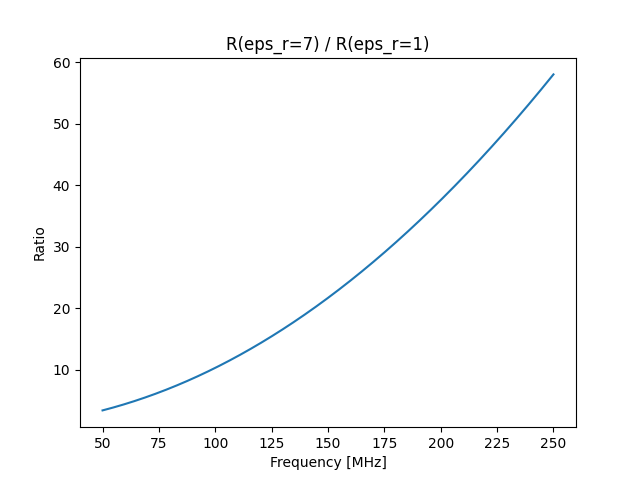

In [7]:
EPS_R = 7  # some mix of limestone and shale
sigma = etu.conductivity_from_resistivity(RESISTIVITY_OHM_M)

# ensure we get the same value as before for eps_r=1
n_memo = etu.complex_ref_index(1, sigma, freqs)
r_memo = reflection_coefficient(n_memo)
print(np.allclose(gamma, r_memo))

# the old conductivity_to_permittivity still works for eps_r=1
n_memo2 = etu.permittivity_from_conductivity(sigma, freqs)
print(np.allclose(n_memo, n_memo2))

# realistic reflection coefficient
n_tilde = etu.complex_ref_index(EPS_R, sigma, freqs)
r_realistic = reflection_coefficient(n_tilde)


plt.figure()
plt.plot(freqs/1e6, r_realistic/r_memo)
plt.title(f"R(eps_r={EPS_R}) / R(eps_r=1)")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Ratio")
plt.show()

Expected height = 1, Actual height = 1.0
Expected height = 5, Actual height = 1.0
Expected height = 10, Actual height = 13.555555555555555
Expected height = 25, Actual height = 26.11111111111111
Expected height = 50, Actual height = 51.22222222222222
Expected height = 75, Actual height = 76.33333333333333
Expected height = 100, Actual height = 101.44444444444444


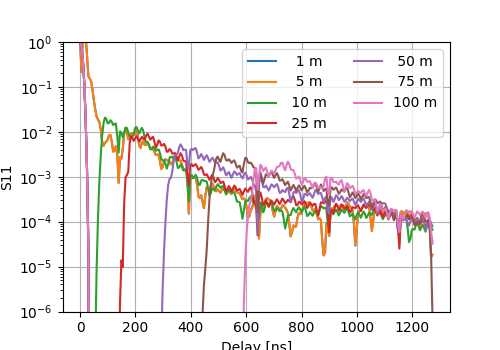

In [8]:
plt.figure(figsize=(5, 3.5))
for height in [1, 5, 10, 25, 50, 75, 100]:
    ix = np.argmin(np.abs(heights-height))
    print(f"Expected height = {height}, Actual height = {heights[ix]}") 
    rmag = npz["r"][ix]
    is_gnd = ~np.isnan(rmag)
    weights = 1 / rmag[is_gnd]  # incoherent scattering, for voltage
    hist, _ = np.histogram(2 * rmag[is_gnd] / c, weights=weights, bins=bin_edges)
    spec = 1 + np.fft.irfft(hist) * r_realistic * (1 - S11)**2  # square 1-S11 to account for out and back
    dspec = np.fft.rfft(spec * window)
    dspec /= dspec[0]
    plt.semilogy(tau_bins * 1e9, np.abs(dspec), label=f'{height:3.0f} m')
plt.ylim(1e-6, 1e0)
plt.ylabel('S11')
plt.grid()
plt.legend(ncol=2, loc='best')
plt.xlabel('Delay [ns]')
#plt.tight_layout()
plt.show()